### Hidden Markov Model

Hiden Markov Model assume there are hidden state of a series, and the state determine the probability of response onset, and states can transfer from each other.    
- As you can see, the series is affected by previous state and will alter through time.

Codes below will demo:    
1. HMM on full scale data
2. HMM on lower dim data
___

In [14]:
# import and define
# NOTE HMM model on windows sometimes cause memory oveflow and raise an error. Save frequently.

import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from Atlas_Corr_Tools import  Mask_Generator
import Common_Functions as cf
import copy
from tqdm import  tqdm
import cv2


wp = r'D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Wild_Type\Preprocessed'
MG = Mask_Generator(bin=4)

on_response,on_mask = cf.Load_Variable(wp,'Response_1d.pkl')

X = on_response.T # input must be in shape N_time x N_feature


___
- ##### Part 1, HMM on response matrix.
Input high dimension response vector, and do HMM estimation on graph.    
Read the doc here: https://hmmlearn.readthedocs.io/en/latest/

In [2]:
# NOTE that HMM on server have bugs, so it might crash from time to time.. Local machine don't have such problem.
import os
os.environ["OMP_NUM_THREADS"] = '1.' 
# set this can reduce probability of bug, but still will be bugs.


# Initialize the HMM
model = hmm.GaussianHMM(n_components=7, covariance_type="diag",n_iter = 10000,tol=0.001) # bigger n_components will lead an o2 time cost, be aware.
# model = hmm.GMMHMM(n_components=7, covariance_type="diag",n_iter = 10000,tol=0.0001) 

# n_components: Number of hidden states
# covariance_type: type of covariance, 
# n_iter : max time of iteration
# tol : min error limitation

# train and save the model.
model.fit(X)
cf.Save_Variable(wp,'HMM_Model',model)



True

- After fit, model will return you estimated hidden states, transfer probability, and average of each state.     


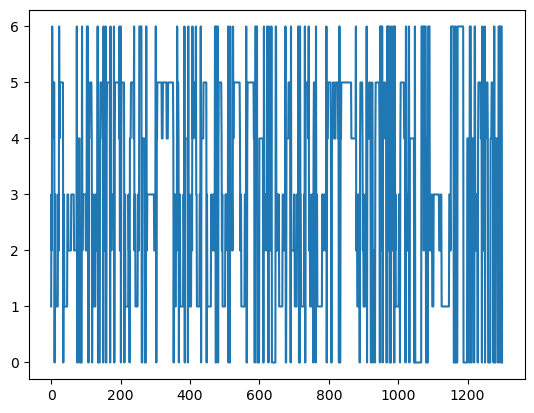

In [2]:
model = cf.Load_Variable(wp,'HMM_Model.pkl')

# state alteration by time
hidden_states = model.predict(X) 
plt.plot(hidden_states[10000:11300])


- And you can get transfer probability of different states.

<AxesSubplot: >

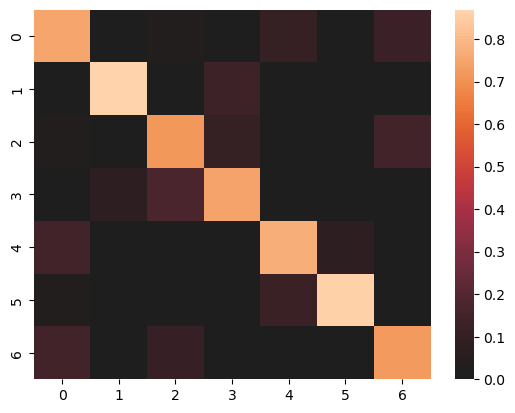

In [3]:
transition_matrix = model.transmat_ # probability of each state's alteration to each other
sns.heatmap(transition_matrix,center=0)

# Below seems buggy, ignore it.
# state_covariance_matrices = model.covars_ # covariance matrix of each state, in shape N_State*N_feature*N_feature

- And you can show Average of each model.

In [4]:
all_mats = model.means_ # mean response of each state
# all_mats = model.means_[:,0,:] # for GMMHMM

def Recover_Map(vec,mask):
    recover = copy.deepcopy(on_mask).astype('f8')
    recover[recover==True] = vec
    return recover


savepath = cf.join(wp,'HMM_State_Avr')
cf.mkdir(savepath)
for i in tqdm(range(len(all_mats))):
    c_map = Recover_Map(all_mats[i,:],on_mask)
    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_map,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)



Folder D:\ZR\_Data_Temp\Ois200_Data\Full_Demo\Wild_Type\Preprocessed\HMM_State_Avr already exists!


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


<Figure size 640x480 with 0 Axes>

- The amazing part of HMM is that it can predict and generate new data similar to series you give.    
But it seems that lower dim or higher iteration will work better..

<AxesSubplot: >

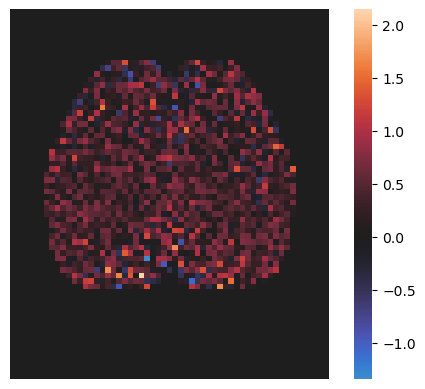

In [9]:
# Use model.sample to generate artificial response.
X, Z = model.sample(1)

generated_graph = Recover_Map(X[0,:],on_mask)
sns.heatmap(generated_graph,xticklabels=False,yticklabels=False,square=True,center=0)

___
- ##### Part 2, HMM on area response matrix.
- As you can see, generating method works not good enough, so we try it on lower dim data.    
  


In [4]:
# Type 2, HMM on lower dim data.
# load masked series.
series = np.load(cf.join(wp,'z_series.npy'))
mask = cv2.imread(cf.join(wp,'Chamber_mask.png'),0)>0
mask = mask*mask[:,::-1]
joint_mask = (series.std(0)>0)*mask
series = series*joint_mask

In [22]:
# calculate area response matrix.
init_resp = MG.Avr_By_Area(series[0,:,:])
area_names = init_resp['Name']
area_num = len(init_resp)

area_resp = np.zeros(shape = (len(series),area_num),dtype = 'f8')
for i in tqdm(range(len(series))):
    area_resp[i,:] = np.array(MG.Avr_By_Area(series[i,:,:])['Response'])

cf.Save_Variable(wp,'Area_Respnose',(area_resp,area_names))


100%|██████████| 18025/18025 [33:02<00:00,  9.09it/s]


True

Fit HMM model on area averaged data.

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = '1.'

area_resp,area_names = cf.Load_Variable(wp,'Area_Respnose.pkl')

model_c = hmm.GaussianHMM(n_components=7, covariance_type="diag",n_iter = 10000,tol=0.001)
model_c.fit(area_resp)

cf.Save_Variable(wp,'HMM_Model_Clustered',model_c)


True

<AxesSubplot: >

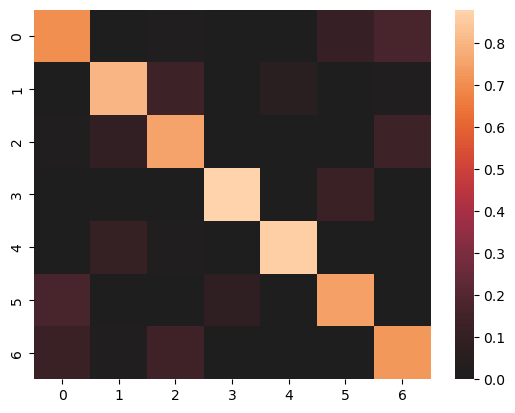

In [10]:
# show transition matrix
transition_matrix = model_c.transmat_ # probability of each state's alteration to each other
sns.heatmap(transition_matrix,center=0)

In [13]:
all_mats = model_c.means_

savepath = cf.join(wp,'HMM_State_Area_Clusters')
cf.mkdir(savepath)
for i in range(len(all_mats)):
    c_map = MG.Get_Weight_Map(area_names,all_mats[i,:])
    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_map,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)
    

<Figure size 640x480 with 0 Axes>

Generate New response series, and compare with real series.

<AxesSubplot: >

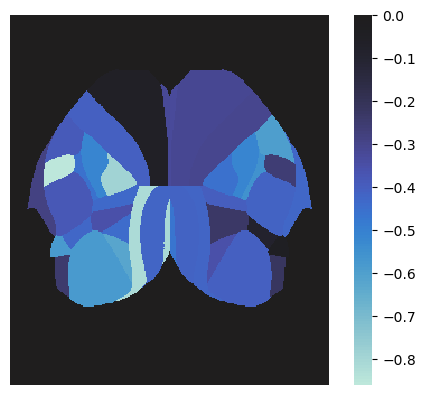

In [39]:
model_c = cf.Load_Variable(wp,'HMM_Model_Clustered.pkl')

# Use model.sample to generate artificial response.
X_gen, Z_gen = model_c.sample(500) # generated graph,it's hidden state

generated_graph = MG.Get_Weight_Map(area_names,X_gen[24,:])
sns.heatmap(generated_graph,xticklabels=False,yticklabels=False,square=True,center=0)


- Here comes the interesting part, generated series have similar temporal information to real data.

<AxesSubplot: >

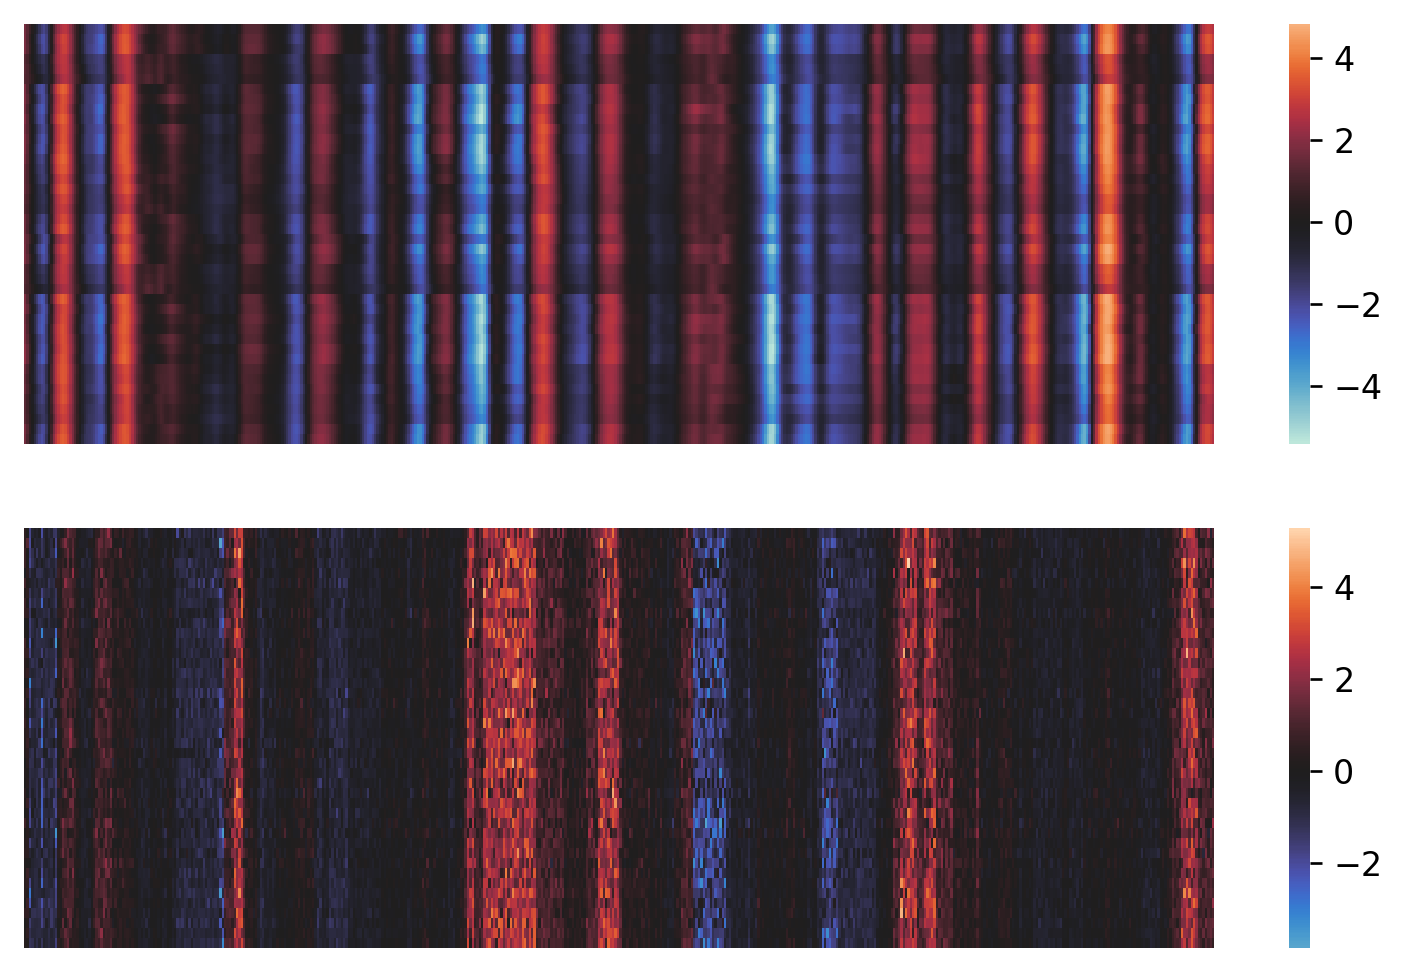

In [40]:
fig,ax = plt.subplots(ncols=1,nrows=2,figsize = (8,5),dpi = 240)

sns.heatmap(area_resp[10000:10500,:].T,xticklabels=False,yticklabels=False,ax = ax[0],center=0)
sns.heatmap(X_gen.T,xticklabels=False,yticklabels=False,ax = ax[1],center=0)


As you can see above, HMM model simulates the similar global ensemble of spon, but still lacks precision on details.